In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import math

def psy_analytic(x, lamb = 1, case = 1):
    '''
        psy_analytic = np.exp(lamb*x)
    '''
    if case == 1:
        return tf.exp(lamb*x)
    elif case == 2:
        return tf.sin(x)
    elif case == 3:
        return -1 / (1 + x)

def A(x, case = 1):
    if case == 1:
        return -1

def B(x, case = 1):
    if case == 1:
        return 0

def f(x, psy, case = 1):
    if case == 1:
        '''
            d(psy)/dx = f(x, psy)
            y' = B(x) - A(x) * y
        '''
        return B(x) - A(x)*psy
    
    elif case == 2:
        '''
            Prothero Robinson
            y' 
        '''
        return -(psy - tf.sin(x)) + tf.cos(x)

    elif case == 3:
        return psy**2

def y(x, w, case = 1): 
    '''
        y(x) = bias + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
    '''
    if case == 1:
        bias = 1.
    elif case == 2:
        bias = 0.
    elif case == 3:
        bias = -1.

    y = bias
    w_v = w.variables[0]
    n = w_v.shape[0]
    for i in range(1, n+1):
        y += w_v[i-1]*x**i
    
    return y

def y_loss(x, w, case = 1):
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형
    
    # x_0 = tf.zeros((1, 1))
    # one = tf.ones((1, 1))
    
    with tf.GradientTape() as tape:
        tape.watch(x)

        _y = y(x, w, case = case)
        d_y = tape.gradient(_y, x)
    
    _loss = d_y - f(x, _y, case)
    square_loss = tf.square(_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def y_EC_loss(x, w, NN, case = 1):
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형
    x_0 = tf.zeros((1, 1))
    one = tf.ones((1, 1))
    w_v = w.variables[0]
    n = w_v.shape[0]

    with tf.GradientTape() as tape:
        tape.watch(x)

        y_EC = tf.add(y(x, w, case), NN(x)*x)
        d_y_EC = tape.gradient(y_EC, x)

    _loss = d_y_EC - f(x, y_EC, case)
    init_loss = NN(x_0) - one
    square_loss = tf.square(_loss) + tf.square(init_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def train(train_x, n, case):
    NN = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    w = tf.Module()
    w.v = tf.Variable(tf.random.normal(shape=(n, ), dtype=tf.float32))

    print('start y')
    for itr in range(3000):
        with tf.GradientTape() as tape:
            train_loss = y_loss(train_x, w, case)

            grad_w = tape.gradient(train_loss, w.trainable_variables)
            optimizer.apply_gradients(zip(grad_w, w.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss : {}'.format(itr, train_loss.numpy()))

    print('start y + EC')
    for itr in range(3000):
        with tf.GradientTape() as tape:
            train_loss = y_EC_loss(train_x, w, NN, case)

            grad_NN = tape.gradient(train_loss, NN.trainable_variables)
            optimizer.apply_gradients(zip(grad_NN, NN.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss : {}'.format(itr, train_loss.numpy()))
    
    return w, NN

def result_pred(train_x, case, w, NN):
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형

    pred_y = y(test_x, w, case)
    NN_pred_y = tf.add(y(test_x, w, case), NN.predict(test_x)*test_x)

    test_x = np.linspace(0, 1, 100)
    train_y = psy_analytic(train_x, case = case)
    true_y = psy_analytic(test_x, case = case)

    return pred_y, NN_pred_y, train_y, true_y

def graph_show(train_x, train_y, true_y, pred_y, NN_pred_y):
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형
    fig = plt.figure(figsize=(18,5))
    ax = fig.add_subplot(121)
    ax.plot(train_x, train_y, 'ob', label = 'Train')
    ax.plot(test_x, true_y, '-k', label = 'True')
    ax.plot(test_x, pred_y, '--r', label = 'Prediction')
    ax.plot(test_x, NN_pred_y, '--g', label = 'NN_Prediction')
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=20)
    ax.grid()
    # Error
    ax2 = fig.add_subplot(122)
    plt.plot(test_x, tf.abs(np.array(pred_y).flatten() - true_y), '-r', label = 'Error')
    plt.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-g', label = 'NN_Error')
    ax2.tick_params(labelsize=10)
    ax2.legend(fontsize=20)
    ax2.grid()

start y
iter : 0, loss : 0.6909447312355042
iter : 1000, loss : 0.3593267798423767
iter : 2000, loss : 0.3378832936286926
start y + EC
iter : 0, loss : 1.342262625694275
iter : 1000, loss : 0.02684679813683033
iter : 2000, loss : 0.017759568989276886
4/4 [==============================] - 0s 2ms/step


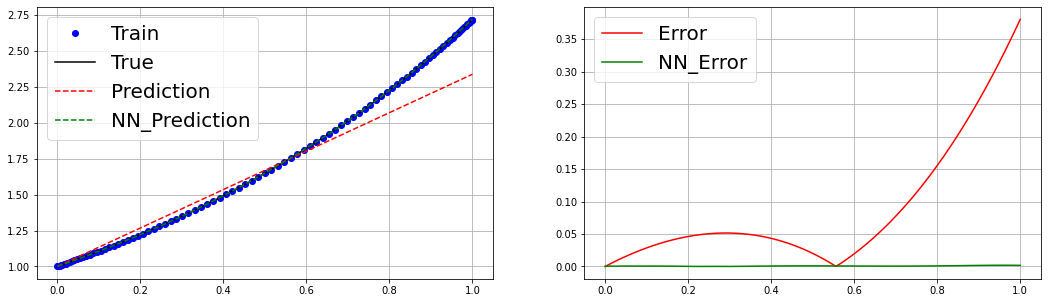

In [8]:
# train_x = (np.random.rand(30)).reshape(-1, 1)
train_x = np.array([(1 + tf.cos((i/100)*math.pi))/2 for i in range(100)]).reshape((-1, 1))

n = 1
case = 1
w, NN = train(train_x, n, case)

pred_y, NN_pred_y, train_y, true_y = result_pred(train_x, case, w, NN)

# Graph
graph_show(train_x, train_y, true_y, pred_y, NN_pred_y)

start y
iter : 0, loss : 1.4679983854293823
iter : 1000, loss : 0.2936441898345947
iter : 2000, loss : 0.049486469477415085
start y + EC
iter : 0, loss : 1.0067631006240845
iter : 1000, loss : 0.011677750386297703
iter : 2000, loss : 0.007760681677609682
4/4 [==============================] - 0s 2ms/step


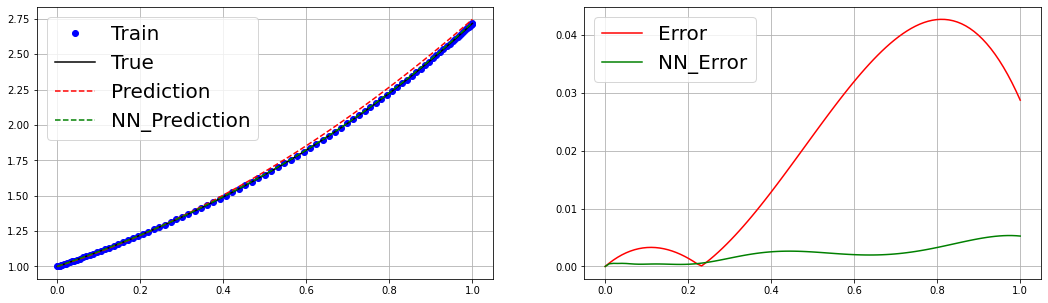

In [10]:
# train_x = (np.random.rand(30)).reshape(-1, 1)
n = 2
case = 1
w, NN = train(train_x, n, case)

pred_y, NN_pred_y, train_y, true_y = result_pred(train_x, case, w, NN)

# Graph
graph_show(train_x, train_y, true_y, pred_y, NN_pred_y)

start y
iter : 0, loss : 5.031177997589111
iter : 1000, loss : 0.4819532632827759
iter : 2000, loss : 0.020113162696361542
start y + EC
iter : 0, loss : 1.0172697305679321
iter : 1000, loss : 0.00886547565460205
iter : 2000, loss : 0.010750054381787777
4/4 [==============================] - 0s 2ms/step


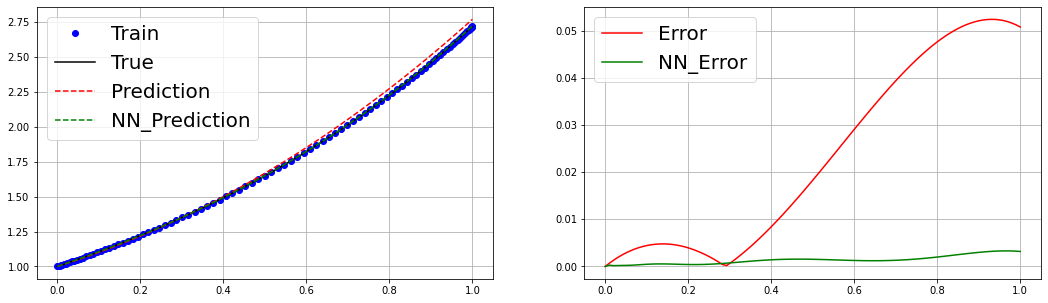

In [11]:
# train_x = (np.random.rand(30)).reshape(-1, 1)
n = 3
case = 1
w, NN = train(train_x, n, case)

pred_y, NN_pred_y, train_y, true_y = result_pred(train_x, case, w, NN)

# Graph
graph_show(train_x, train_y, true_y, pred_y, NN_pred_y)

start y
iter : 0, loss : 2.545835494995117
iter : 1000, loss : 0.21187610924243927
iter : 2000, loss : 0.030514264479279518
start y + EC
iter : 0, loss : 1.2482807636260986
iter : 1000, loss : 0.011623338796198368
iter : 2000, loss : 0.007818101905286312
4/4 [==============================] - 0s 7ms/step


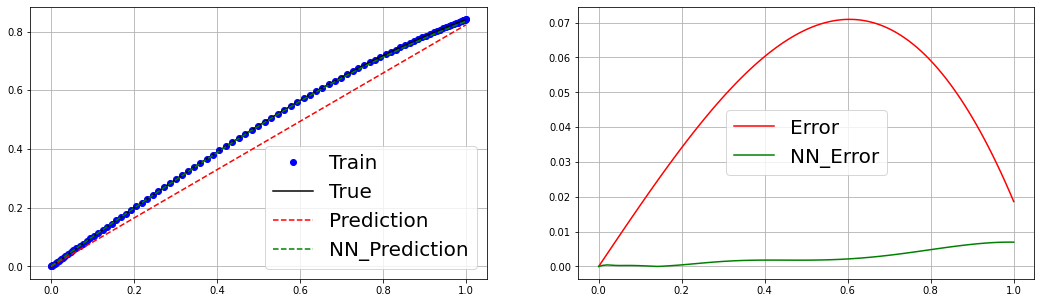

In [12]:
# train_x = (np.random.rand(30)).reshape(-1, 1)
n = 1
case = 2
w, NN = train(train_x, n, case)

pred_y, NN_pred_y, train_y, true_y = result_pred(train_x, case, w, NN)

# Graph
graph_show(train_x, train_y, true_y, pred_y, NN_pred_y)

start y
iter : 0, loss : 3.48618221282959
iter : 1000, loss : 0.42107731103897095
iter : 2000, loss : 0.2300494760274887
start y + EC
iter : 0, loss : 1.090997338294983
iter : 1000, loss : 0.013257065787911415
iter : 2000, loss : 0.007626409642398357
4/4 [==============================] - 0s 2ms/step


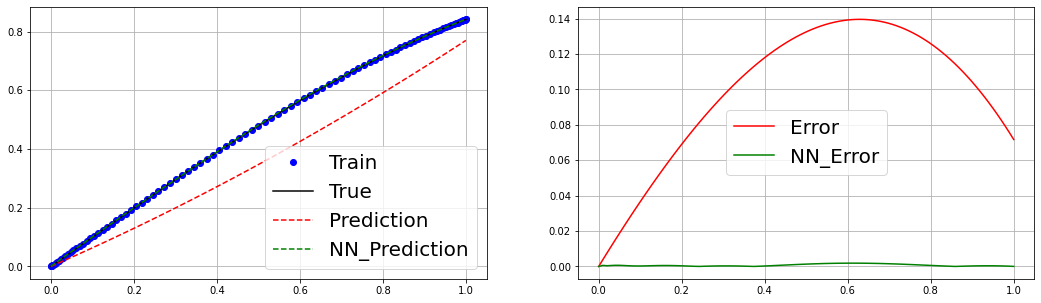

In [13]:
# train_x = (np.random.rand(30)).reshape(-1, 1)
n = 2
case = 2
w, NN = train(train_x, n, case)

pred_y, NN_pred_y, train_y, true_y = result_pred(train_x, case, w, NN)

# Graph
graph_show(train_x, train_y, true_y, pred_y, NN_pred_y)

start y
iter : 0, loss : 25.539072036743164
iter : 1000, loss : 1.533799171447754
iter : 2000, loss : 0.02172798104584217
start y + EC
iter : 0, loss : 1.0213923454284668
iter : 1000, loss : 0.019135823473334312
iter : 2000, loss : 0.01251445896923542
4/4 [==============================] - 0s 2ms/step


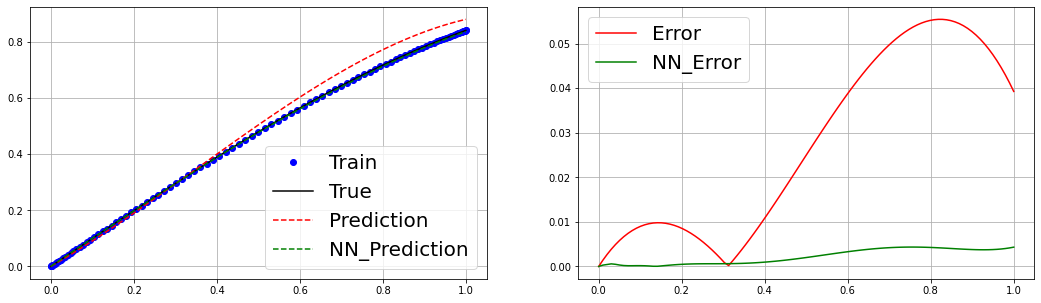

In [14]:
# train_x = (np.random.rand(30)).reshape(-1, 1)
n = 3
case = 2
w, NN = train(train_x, n, case)

pred_y, NN_pred_y, train_y, true_y = result_pred(train_x, case, w, NN)

# Graph
graph_show(train_x, train_y, true_y, pred_y, NN_pred_y)

start y
iter : 0, loss : 1.4795310497283936
iter : 1000, loss : 0.09197462350130081
iter : 2000, loss : 0.07764951884746552
start y + EC
iter : 0, loss : 1.18755304813385
iter : 1000, loss : 0.007467151153832674
iter : 2000, loss : 0.005425034556537867
4/4 [==============================] - 0s 2ms/step


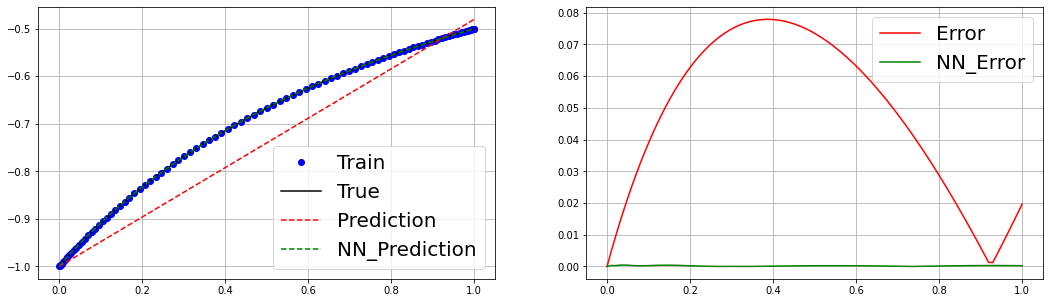

In [15]:
# train_x = (np.random.rand(30)).reshape(-1, 1)
n = 1
case = 3
w, NN = train(train_x, n, case)

pred_y, NN_pred_y, train_y, true_y = result_pred(train_x, case, w, NN)

# Graph
graph_show(train_x, train_y, true_y, pred_y, NN_pred_y)

start y
iter : 0, loss : 4.516778469085693
iter : 1000, loss : 0.06790271401405334
iter : 2000, loss : 0.03651469573378563
start y + EC
iter : 0, loss : 1.6017755270004272
iter : 1000, loss : 0.010976353660225868
iter : 2000, loss : 0.007158743683248758
4/4 [==============================] - 0s 2ms/step


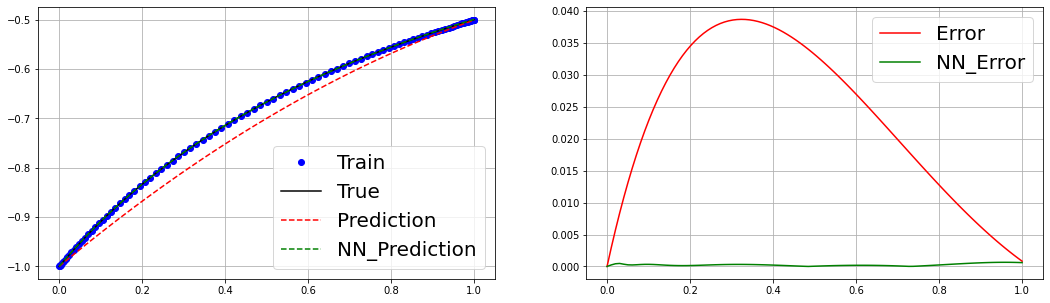

In [16]:
# train_x = (np.random.rand(30)).reshape(-1, 1)
n = 2
case = 3
w, NN = train(train_x, n, case)

pred_y, NN_pred_y, train_y, true_y = result_pred(train_x, case, w, NN)

# Graph
graph_show(train_x, train_y, true_y, pred_y, NN_pred_y)

start y
iter : 0, loss : 3.2639472484588623
iter : 1000, loss : 0.20137740671634674
iter : 2000, loss : 0.04151292145252228
start y + EC
iter : 0, loss : 1.0364564657211304
iter : 1000, loss : 0.017350733280181885
iter : 2000, loss : 0.0075811464339494705
4/4 [==============================] - 0s 2ms/step


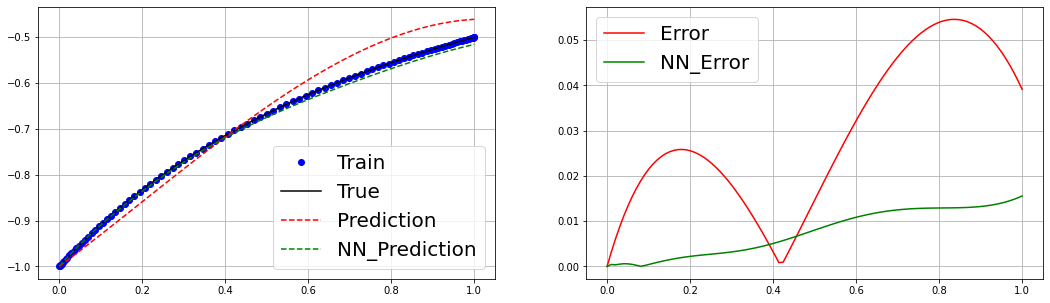

In [17]:
# train_x = (np.random.rand(30)).reshape(-1, 1)
n = 3
case = 3
w, NN = train(train_x, n, case)

pred_y, NN_pred_y, train_y, true_y = result_pred(train_x, case, w, NN)

# Graph
graph_show(train_x, train_y, true_y, pred_y, NN_pred_y)